# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 140000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (140000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(118907, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.93357142857143

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

Observation(s):

1. I have keep only those values whose HelpfulnessNumerator <= HelpfulnessDenominator.

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(118905, 10)


1    99869
0    19036
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_118904 = final['Text'].values[118904]
print(sent_118904)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.strongly recommend


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

Purchased this product at a local store in NY and my kids and i love it Its a quick easy meal You can put in a toaster oven on toast for 6 min and its ready to eat br strongly recommend


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

Observation(s):

1. Here we are having set of stopwords.
2. Here so many unused word in the stopwords.
3. stopwords are words which contain a dictionary of unused words.
4. If we are removing stopwordsthen our Bag of Words is much smaller and meaningful vector.

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [01:45<00:00, 1122.45it/s]


In [23]:
preprocessed_reviews[118904]

'purchased product local store ny kids love quick easy meal put toaster oven toast min ready eat strongly recommend'

In [24]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews
final['CleanedText']=final['CleanedText']
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (118905, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138687,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,Get the movie or sound track and sing along wi...,get movie sound track sing along carol king gr...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,1,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,summary young boy describes usefulness chicken...


Observation(s):

1. Here processed review can be seen in the CleanedText Column.
2. We will use it for future observation.
3. we are having 118905 matrix of features.

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_118904 = final['Summary'].values[118904]
print(sent_118904)
print("="*50)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

A classic


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

DELICIOUS


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

A classic


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

DELICIOUS


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_Summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [01:10<00:00, 1697.33it/s]


In [34]:
preprocessed_Summary = [118904]
print (preprocessed_Summary)

[118904]


# Time Based Splitting

In [36]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 20K datapoints

# We will collect different 20K rows without repetition from time_sorted_data dataframe
final_20 = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(final_20.shape)
final_20.head(3)

(100000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
73921,80432,B000EDBQ38,AY1ZTV87QPCTJ,Perry M. Gould,0,0,1,1316304000,Kate's review,I could not find Bob's red mill rice bran in a...,could not find bob red mill rice bran grocery ...
12742,13902,B002KE92UI,A1BCZ9QZ55YVO8,"F. Mills ""A privilege to meet you""",1,1,1,1337472000,So good I only got one taste,"I bought a small bottle in Chapel Hill, NC, bu...",bought small bottle chapel hill nc not pop ope...
92507,100604,B0029NU31M,A1BFRTDMLD15UR,Lucy Galvez,0,0,0,1348185600,poor taste,Just when i got my shipment i tried it out on ...,got shipment tried pit ate portion never ate a...


Observation(s):
1. Time based splitting is better than random splitting.
2. In time based splitting we sort our data in ascending order.
3. In TIme based splitting we get better accuracy than random splitting.

In [37]:
# sample dataset 
final_20['Score'].value_counts()

1    83967
0    16033
Name: Score, dtype: int64

In [38]:
# Original dataset
final['Score'].value_counts()

1    99869
0    19036
Name: Score, dtype: int64

In [39]:
# Ratio of positive reviews to negative reviews in Sample Dataset
len(final_20[final_20['Score'] == 1])/len(final_20[final_20['Score'] == 0])

5.237135907191417

In [40]:
# Ratio of positive reviews to negative reviews in Original Dataset
len(final[final['Score'] == 1])/len(final[final['Score'] == 0])

5.246322756881698

In [41]:
# final_20 datapoints which will use to train model
X = final_20['CleanedText'].values
print("shape of X:", X.shape)

shape of X: (100000,)


In [42]:
# class label
y = final_20['Score'].values
print("shape of y:", y.shape)

shape of y: (100000,)


In [43]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# Splitting the data set into training set and test set:
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_cv.shape, Y_cv.shape)

(53600,) (53600,) (20000,) (20000,) (26400,) (26400,)


Observation(s):
    
1. I have split the dataset into training set and testing set.
2. Here 80% of the data used to train the model and 20% of the data used to test its performance of the test set.
3. Here i have 53600 points to train the model and 20000 points to test its performance on the test set.

# [4] Featurization

## [4.1] BAG OF WORDS

In [44]:
#BoW
#https://www.kaggle.com/rochachan/part-1-for-beginners-bag-of-words
from sklearn.feature_extraction.text import CountVectorizer    #in scikit-learn
count_vect = CountVectorizer(min_df = 20, max_features=500).fit(X_train) # Here I am fitting my CountVectorizer function  into X_train and Then transform into X_train and X_test. 
# we also use fit_transform method for training set. I am doind it for auc
# min_df = 20;min_df = 20, which will remove any words from our vocabulary that appear in fewer than five documents.
# https://towardsdatascience.com/scikit-learn-for-text-analysis-of-amazon-fine-food-reviews-ea3b232c2c1b
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
print("the type of count vectorizer :",type(X_train_bow))
print("the shape of out text BOW vectorizer : ",X_train_bow.get_shape())
print("the number of unique words :", X_train_bow.get_shape()[1])

After vectorizations
(53600, 500) (53600,)
(26400, 500) (26400,)
(20000, 500) (20000,)
some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also', 'alternative']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (53600, 500)
the number of unique words : 500


## [4.2] Bi-Grams and n-Grams.

In [45]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=20, max_features=500).fit(X_train)
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (53600, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df=50, max_features=500).fit(X_train)
X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer :",type(X_train_tf_idf))
print("the shape of out text TFIDF vectorizer : ",X_train_tf_idf.get_shape())
print("the number of unique words :", X_train_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also', 'alternative']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (53600, 500)
the number of unique words : 500


In [58]:
print("the number of unique words :", X_test_tf_idf.get_shape()[1])

the number of unique words : 500


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [46]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# Creating alpha values in the range from 10^-4 to 10^4. i.e. 10^-4, 10^-3, 10^-2, 10^-1, 10^-5, 1, 10^1, 10^2, 10^3, 10^4
neighbors = []
i = 0.0001
while(i<=10000):
    neighbors.append(np.round(i,4))
    i *= 4

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    mn = MultinomialNB(alpha = k)
    scores = cross_val_score(mn, X_cv_bow, Y_cv, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# determining best value of alpha
optimal_alpha = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.410.


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

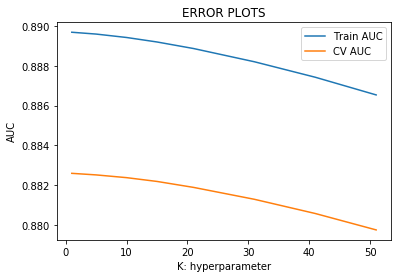

In [47]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    mn = MultinomialNB(alpha = i)
    mn.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  mn.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  mn.predict_proba(X_cv_bow)[:,1]
    # https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

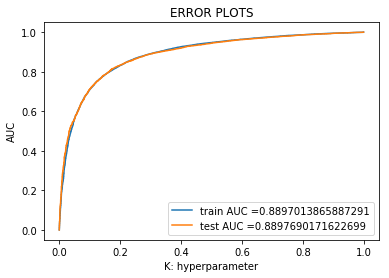

Train confusion matrix
[[ 4884  3670]
 [ 2994 42052]]
Test confusion matrix
[[ 1843  1428]
 [ 1155 15574]]
Test AUC is: 0.8897690171622699


In [48]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


mn = MultinomialNB(alpha = 0.410)
mn.fit(X_train_bow, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, mn.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, mn.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, mn.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, mn.predict(X_test_bow)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
bow_multinomial_auc = roc_auc_score(Y_test, mn.predict_proba(X_test_bow)[:,1])
print("Test AUC is:", bow_multinomial_auc)

In [49]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== Multinomial Naive Bayes with alpha = optimal_alpha ============================================
# instantiate learning model alpha = optimal_alpha
mn_optimal = MultinomialNB(alpha = optimal_alpha)

# fitting the model
mn_optimal.fit(X_train_bow, Y_train)

# predict the response
Y_pred = mn_optimal.predict(X_test_bow)

# evaluate accuracy
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_multinomial_alpha = optimal_alpha
bow_multinomial_train_acc = max(cv_scores)*100
bow_multinomial_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.410 is 87.085000%


Observation(s):
    
1. The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.410 is 87.085000%.

# Confusion Matrix of Training Set Of BOW Model

In [50]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, mn.predict(X_train_bow)))
cm

array([[ 4884,  3670],
       [ 2994, 42052]], dtype=int64)

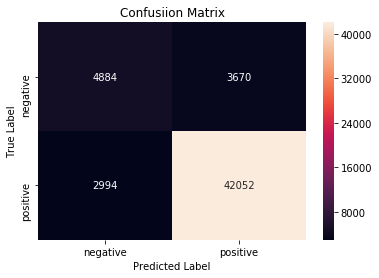

In [51]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of BOW Model.
1. As we have seen on confusion matrix, we have 42052 + 4884 = 46936 correct prediction on training set.
2. Acccuracy of 46936 correct prediction on training set is 87.567%.

# Confusion Matrix For Test Set Of BOW Model

In [54]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, mn.predict(X_test_bow)))
cm

array([[ 1843,  1428],
       [ 1155, 15574]], dtype=int64)

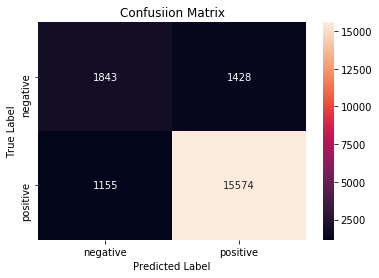

In [55]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of BOW Model.
2. As we have seen on confusion matrix, we have 15574 + 1843 = 17417 correct prediction on test set.
2. Acccuracy of 17417 correct prediction on test set is 87.085000%.

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [52]:
# Now we can find log probabilities of different features for 'positive' classes
class_features = mn_optimal.feature_log_prob_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# row_1 is for 'positive' class
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order using argsort() function
sorted_positive_features = np.argsort(positive_features)[::-1]
    
print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))



Top 10 Important Features and their log probabilities For Positive Class :


not	 -->	-3.214352  
like	 -->	-4.027852  
good	 -->	-4.172610  
great	 -->	-4.247102  
one	 -->	-4.369586  
coffee	 -->	-4.405812  
taste	 -->	-4.466961  
flavor	 -->	-4.559313  
would	 -->	-4.568917  
love	 -->	-4.581559  


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [53]:
# Now we can find log probabilities of different features for 'negative' classes
class_features = mn_optimal.feature_log_prob_    # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
#  row_0 is for 'negative' class
negative_features = class_features[0]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]

print("Top 10 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))


Top 10 Important Features and their log probabilities For Negative Class :


not	 -->	-2.731791  
like	 -->	-3.826795  
would	 -->	-4.110063  
product	 -->	-4.121990  
taste	 -->	-4.138698  
one	 -->	-4.329514  
coffee	 -->	-4.440971  
no	 -->	-4.571341  
good	 -->	-4.575828  
flavor	 -->	-4.619965  


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [59]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# Creating alpha values in the range from 10^-4 to 10^4. i.e. 10^-4, 10^-3, 10^-2, 10^-1, 10^-5, 1, 10^1, 10^2, 10^3, 10^4
neighbors = []
i = 0.0001
while(i<=10000):
    neighbors.append(np.round(i,4))
    i *= 4

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    mn = MultinomialNB(alpha = k)
    scores = cross_val_score(mn, X_cv_tf_idf, Y_cv, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# determining best value of alpha
optimal_alpha = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.7f.' % optimal_alpha)


The optimal value of alpha is 0.0001000.


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

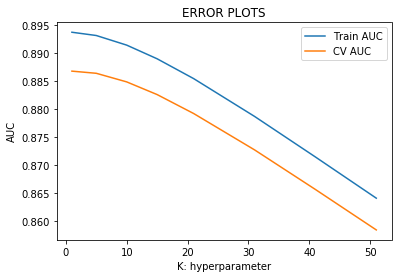

In [60]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    mn = MultinomialNB(alpha = i)
    mn.fit(X_train_tf_idf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  mn.predict_proba(X_train_tf_idf)[:,1]
    Y_cv_pred =  mn.predict_proba(X_cv_tf_idf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

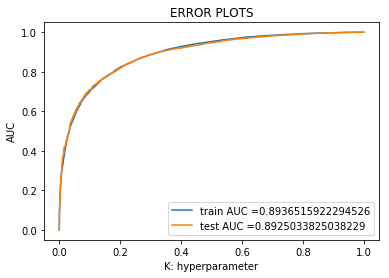

Train confusion matrix
[[  241  8313]
 [   11 45035]]
Test confusion matrix
[[   79  3192]
 [    7 16722]]
Test AUC is: 0.8925033825038229


In [61]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

mn = MultinomialNB(alpha = 0.0001000)
mn.fit(X_train_tf_idf, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, mn.predict_proba(X_train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, mn.predict_proba(X_test_tf_idf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, mn.predict(X_train_tf_idf)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, mn.predict(X_test_tf_idf)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_multinomial_auc = roc_auc_score(Y_test, mn.predict_proba(X_test_tf_idf)[:,1])
print("Test AUC is:", tfidf_multinomial_auc)

In [62]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== Multinomial Naive Bayes with alpha = optimal_alpha ============================================
# instantiate learning model alpha = optimal_alpha
mn_optimal = MultinomialNB(alpha = optimal_alpha)

# fitting the model
mn_optimal.fit(X_train_tf_idf, Y_train)

# predict the response
Y_pred = mn_optimal.predict(X_test_tf_idf)

# evaluate accuracy
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.7f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_multinomial_alpha = optimal_alpha
tfidf_multinomial_train_acc = max(cv_scores)*100
tfidf_multinomial_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.0001000 is 84.005000%


Observation(s):
    
1. The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.0001000 is 84.005000%.

# Confusion Matrix of Training Set Of TFIDF Model

In [65]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, mn.predict(X_train_tf_idf)))
cm

array([[  241,  8313],
       [   11, 45035]], dtype=int64)

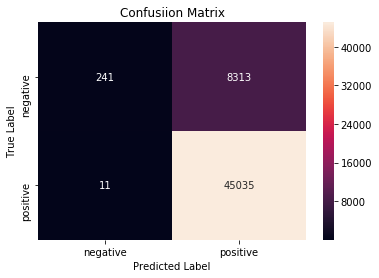

In [66]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF Model.
1. As we have seen on confusion matrix, we have 45035 + 241 = 45276 correct prediction on training set.
2. Acccuracy of 45276 correct prediction on training set is 84.444%.

# Confusion Matrix of Test Set Of TFIDF Model

In [68]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, mn.predict(X_test_tf_idf)))
cm

array([[   79,  3192],
       [    7, 16722]], dtype=int64)

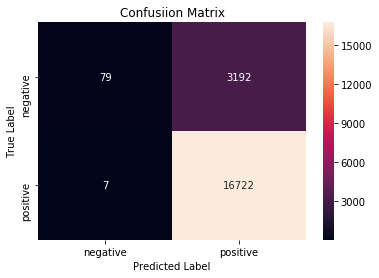

In [69]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF Model.
1. As we have seen on confusion matrix, we have 16722 + 79 = 16801 correct prediction on test set.
2. Acccuracy of 16801 correct prediction on training set is 84.005000%.

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [70]:
mn_optimal.classes_

array([0, 1], dtype=int64)

Observation(s):
    
1. From above we can see that first_class is 0 = 'negative' and second_class is 1 = 'positive'

In [71]:
# Now we can find log probabilities of different features for 'Positive' classes
class_features = mn_optimal.feature_log_prob_# https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance

# row_1 is for 'positive' class
positive_features = class_features[1]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'positive_features' in descending order using argsort() function
sorted_positive_features = np.argsort(positive_features)[::-1]
    
print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))



Top 10 Important Features and their log probabilities For Positive Class :


not	 -->	-4.104217  
great	 -->	-4.448837  
good	 -->	-4.517824  
like	 -->	-4.575027  
coffee	 -->	-4.586246  
love	 -->	-4.698140  
tea	 -->	-4.705659  
one	 -->	-4.802816  
product	 -->	-4.807496  
taste	 -->	-4.821666  


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [72]:
# Now we can find log probabilities of different features for both the classes
class_features = mn_optimal.feature_log_prob_# https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance

#  row_0 is for 'negative' class class
negative_features = class_features[0]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]

print("Top 10 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))

Top 10 Important Features and their log probabilities For Negative Class :


not	 -->	-3.477107  
like	 -->	-4.292275  
product	 -->	-4.362787  
taste	 -->	-4.437465  
would	 -->	-4.440746  
coffee	 -->	-4.611152  
one	 -->	-4.718475  
no	 -->	-4.801841  
flavor	 -->	-4.851980  
even	 -->	-4.955789  


# [6] Conclusions

In [73]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ["MultinomialNB for BoW","MultinomialNB for TFIDF"]

optimal_alpha = [bow_multinomial_alpha, tfidf_multinomial_alpha]

AUC = [bow_multinomial_auc, tfidf_multinomial_auc]

test_acc = [bow_multinomial_test_acc, tfidf_multinomial_test_acc]

numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha",optimal_alpha)
ptable.add_column("AUC",AUC)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+-------------------------+------------+--------------------+-------------------+
| S.NO. |          MODEL          | Best Alpha |        AUC         |   Test Accuracy   |
+-------+-------------------------+------------+--------------------+-------------------+
|   1   |  MultinomialNB for BoW  |   0.4096   | 0.8897690171622699 | 87.08500000000001 |
|   2   | MultinomialNB for TFIDF |   0.0001   | 0.8925033825038229 |       84.005      |
+-------+-------------------------+------------+--------------------+-------------------+


# Procedure Followed:

STEP 1 : Loading The Data
    
STEP 2 : Data Cleaning: Deduplication

STEP 3 : Preprocessing Review Text

STEP 4 : Preprocessing Review Summary

STEP 5 : Time-based splitting of whole dataset into X_train, Y_train, X_test, Y_test, X_cv and Y_cv.

STEP 6 : Applying Featurization Technique to convert text into vector.(i.e. BAG OF WORDS Model)

STEP 7 : Applying Naive Bayes on BOW

STEP 8 : Using Multinomial Naive Bayes as an estimator in 10-Fold Cross-Validation in order to find optimal value of alpha.

STEP 9 : Plotting the performance of model both on train data and cross validation data for each hyper parameter

STEP 10 : Finding the AUC on test data and plotting the ROC curve on both train and test.

STEP 11 : Drawing the confusion matrix using Seaborn Heatmaps.

STEP 12 : Finding the top 10 features of positive class from Set 1.

STEP 13 : Finding top 10 features of negative class from Set 1.

STEP 13 : Repeat STEP 6 to STEP 13 for TFIDF Vectorizer.
